# Vertical profiles from TIGRESS simulations ("zprof")

* During run time, horizontal averages of basic and derived fields are computed and output
* The pre-calculated vertical profiles for each data dump are stored as ascii files (table of z-position and fields) with a dump ID (####) and extension ".zprof" for separate phases (thermal components) and the whole medium (=all phases)
* For MPI jobs,"zprof" files that were dumped from separate processors at a given time must be stitched together before using this notebook. Stiched-together profile files at individual times may also be saved in pickle format with extension .p 
* Profiles that are merged over all time are in pickle (.p extension) or netCDF (.nc extension) format; these may already exist.  This notebook contains a function to merge .zprof files to make netCDF files and place them in directory /zprof_merged
* Note:
    * horizontally integrated variables are stored, i.e. the quantities dumped in the zprof files are
    $$ \langle q \rangle_p \equiv \sum_{i,j} q \Theta(p) \Delta x \Delta y $$
    * for true "horizontal averages", a proper renormalization must be applied, allowing for the number of zones where the phase "p" is present in a given horizontal slice.  
    * The field "A" for a given phase, equal to the horizontal area $\sum_{i,j} \Theta(p) \Delta x \Delta y $, may be used for renormalizing
* $\Theta(p)$ selects just gas within a given phase, i.e. it is nonzero only when the temperature is within a set range:
 * phase1: cold (c),              T < 184 K
 * phase2: unstable (u),   184 K <T < 5050 K 
 * phase3: warm (w),       5050 K <T< $2\times10^4$ K
 * phase4: ionized (h1),    2$\times10^4$ K<T<5$\times10^5$ K
 * phase4: hot (h2),        5$\times10^5$ K<T
 
    
NOTE: Below we use "2p" subscript for sum over c+u+w, i.e. warm-cold ISM
    

In [1]:
%matplotlib inline

In [2]:
# Import standard packages and data array management packages
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import astropy
import cPickle as p
import glob

## Setting up data directory
* You may be using data from simulations that have already been run, or new simulations
* In either case, you will need to set up the directory path information for accessing the zprof data
* For example, the "base" (parent directory for the simulation output) and "problem_id" for the "MHD_4pc_new" simulation that have already been run are:

In [3]:
base='/tigress/changgoo/'
problem_id='MHD_4pc_new'

### To handle multidimensional, labeled data, we use [xarray](https://xarray.pydata.org/en/stable/why-xarray.html) 
* Previously, we used pandas Panel, which is now [deprecated](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#deprecate-panel)

In [4]:
# This is a script to merge all the profiles (from each phase) over all time into xarray DataArrays and store them 
# in the NetCDF format.
# It assumes all of the individual .zprof ascii files are in the directory [base][problem_id]/zprof/
def merge_to_xarray(base,problem_id):
    
    plist=['phase1','phase2','phase3','phase4','phase5','whole']
    for phase in plist:
#This returns a list of all filenames that match the template (here * is the data dump ID ####):        
        zprof_fnames=glob.glob('{}{}/zprof/{}.*.{}.zprof'.format(base,problem_id,problem_id,phase))
        zprof_fnames.sort()

        taxis=[]
        dfall=None
        for f in zprof_fnames:
            fp=open(f,'r')
            hd=fp.readline()
            fp.close()
            time=float(hd[hd.rfind('t=')+2:])
            df=pd.read_csv(f,skiprows=1)
            zaxis=np.array(df['z'])
            fields=np.array(df.columns)
            taxis.append(time)
            if dfall is None:
                dfall=np.array(df)[np.newaxis,:]
            else:
                dfall=np.concatenate([dfall,np.array(df)[np.newaxis,:]],axis=0)
    
        da=xr.DataArray(dfall.T,coords={'fields':fields,'zaxis':zaxis,'taxis':taxis},
                                dims=('fields','zaxis','taxis'))
        zpfile='{}{}/zprof_merged/{}.{}.zprof.nc'.format(base,problem_id,problem_id,phase)
        da.to_netcdf(zpfile)
        print('{} is created'.format(zpfile))

In [5]:
# This checks if merged files already exist in the directory zprof_merged, and if not they are created
import os
if not os.path.isfile('{}{}/zprof_merged/{}.whole.zprof.nc'.format(base,problem_id,problem_id)):
    zpdir='{}{}/zprof_merged/'.format(base,problem_id)
    if not os.path.isdir(zpdir): os.mkdir(zpdir)
    merge_to_xarray(base,problem_id)

In [6]:
#This reads in all of the names of the merged profile files
zprof_fnames=glob.glob('{}{}/zprof_merged/{}.*.zprof.nc'.format(base,problem_id,problem_id))

In [7]:
zprof_fnames.sort()
zprof_fnames

['/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase1.zprof.nc',
 '/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase2.zprof.nc',
 '/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase3.zprof.nc',
 '/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase4.zprof.nc',
 '/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase5.zprof.nc',
 '/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.whole.zprof.nc']

#### Data from the time-merged arrays are loaded with xarray.open_dataarray function
Note that the data is loaded **lazily** from netCDF files. This is useful when one is working with a gigantic data file. For our purpose, it is better to load all the data into memory. To do this, first **load** it and then **close** the file. 

In [8]:
cold=zprof_fnames[0]
unst=zprof_fnames[1]
warm=zprof_fnames[2]
ion=zprof_fnames[3]
hot=zprof_fnames[4]
whole=zprof_fnames[5]
print cold

/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase1.zprof.nc


In [9]:
#Read in data for all gas:
data=xr.open_dataarray(whole)
data.load()
data.close()

In [10]:
#The data array has many horizontally-averaged quantities (values in fields) for each location along 
# the z-axis (values in zaxis) and at each time (values in taxis)
data

<xarray.DataArray (fields: 85, zaxis: 1792, taxis: 702)>
array([[[ 1.048576e+06,  1.048576e+06, ...,  1.048576e+06,  1.048576e+06],
        [ 1.048576e+06,  1.048576e+06, ...,  1.048576e+06,  1.048576e+06],
        ...,
        [ 1.048576e+06,  1.048576e+06, ...,  1.048576e+06,  1.048576e+06],
        [ 1.048576e+06,  1.048576e+06, ...,  1.048576e+06,  1.048576e+06]],

       [[ 0.000000e+00,  1.889327e+01, ..., -3.905239e+04, -2.997081e+04],
        [ 0.000000e+00,  2.635888e+01, ..., -3.846292e+04, -3.023447e+04],
        ...,
        [ 0.000000e+00,  1.178177e+01, ..., -2.101226e+04, -2.481318e+04],
        [ 0.000000e+00,  9.267621e+00, ..., -2.139508e+04, -2.430190e+04]],

       ...,

       [[ 3.129800e+07,  3.067498e+07, ...,  2.730289e+06,  5.671139e+06],
        [ 3.129800e+07,  3.062639e+07, ...,  2.704058e+06,  5.793081e+06],
        ...,
        [ 3.129800e+07,  3.066132e+07, ...,  2.180871e+07,  1.938320e+07],
        [ 3.129800e+07,  3.070929e+07, ...,  2.199950e+07,  1.

In [11]:
print data.dims,data.coords

(u'fields', u'zaxis', u'taxis') Coordinates:
  * fields   (fields) |S9 'A' 'B1' 'B2' 'B3' 'Ber' 'Ek1' 'Ek2' 'Ek3' 'M1' ...
  * taxis    (taxis) float64 0.0 1.0 2.005 3.004 4.007 5.004 6.01 7.004 ...
  * zaxis    (zaxis) float64 -3.582e+03 -3.578e+03 -3.574e+03 -3.57e+03 ...


In [12]:
#  This is the set of variables that is available.  See "Variables in zprof" comment below for additional information,
#  and dump_zprof.c in the TIGRESS Athena code for detailed definitions.  
data.coords['fields']

<xarray.DataArray 'fields' (fields: 85)>
array(['A', 'B1', 'B2', 'B3', 'Ber', 'Ek1', 'Ek2', 'Ek3', 'M1', 'M2', 'M3',
       'MxyL', 'MxyR', 'P', 'PB1', 'PB2', 'PB3', 'Phie', 'Phisg', 'RxyL',
       'RxyR', 'S1', 'S2', 'S3', 'T', 'cool', 'd', 'dB1', 'dB2', 'dB3', 'dEk2',
       'dM2', 'dPB1', 'dPB2', 'dPB3', 'dWext', 'dWsg', 'dvA1', 'dvA2', 'dvA3',
       'gext', 'gsg', 'heat', 'mA', 'mFzE1', 'mFzE2', 'mFzE3', 'mFzEge',
       'mFzEgsg', 'mFzEtidal', 'mFzM1', 'mFzM2', 'mFzM3', 'mFzP', 'mFzd',
       'mSzEm1', 'mSzEm2', 'mSzvB1', 'mSzvB2', 'md', 'mvz', 'pA', 'pFzE1',
       'pFzE2', 'pFzE3', 'pFzEge', 'pFzEgsg', 'pFzEtidal', 'pFzM1', 'pFzM2',
       'pFzM3', 'pFzP', 'pFzd', 'pSzEm1', 'pSzEm2', 'pSzvB1', 'pSzvB2', 'pd',
       'pvz', 'v1', 'v2', 'v3', 'vA1', 'vA2', 'vA3'], dtype='|S9')
Coordinates:
  * fields   (fields) |S9 'A' 'B1' 'B2' 'B3' 'Ber' 'Ek1' 'Ek2' 'Ek3' 'M1' ...

In [13]:
#This is the number of different time outputs:
data.coords['taxis'].size
#This is the number of different z-values:
data.coords['zaxis'].size
#You can find a particular value 
# In this example, we fine the values of field[26] (which is the density 'd'), z[300], and t[100]
print data.coords['fields'][26], data.coords['zaxis'][300],data.coords['taxis'][100], 

<xarray.DataArray 'fields' ()>
array('d', dtype='|S9')
Coordinates:
    fields   |S9 'd' <xarray.DataArray 'zaxis' ()>
array(-2382.)
Coordinates:
    zaxis    float64 -2.382e+03 <xarray.DataArray 'taxis' ()>
array(100.0007)
Coordinates:
    taxis    float64 100.0


81.20837586717971
(85, 1792, 702)
(1792, 702)
81.20837586717971


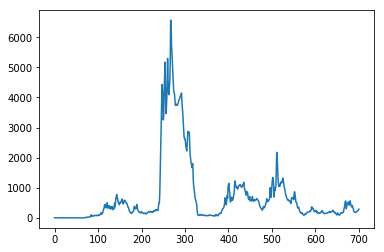

In [14]:
# If you prefer, you can convert the data into a 3D numpy array, with indices [field,z,t]
data_arr=np.array(data)
print data_arr[26,300,100]
# You can also operate on it as a numpy array 
print np.array(data).shape
# or select one field and convert it into 2D numpy array: values of specific field for all [z,t] 
print np.array(data.sel(fields='d')).shape
print np.array(data.sel(fields='d'))[300,100]
d_z300=np.array(data.sel(fields='d'))[300,:]
#This is the values of (integrated) density at location z[300]=-2382. over all time
plt.plot(data.coords['taxis'],d_z300)

81.20837586717971


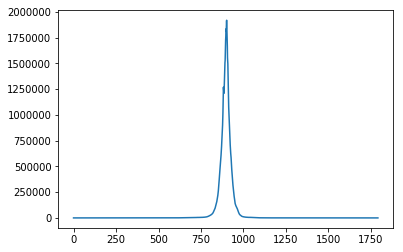

In [15]:
#This is the profile at t[100], using numpy array
dprof=np.array(data.sel(fields='d'))[:,100]
print dprof[300]
plt.plot(dprof)

#### You can still access data as numpy.ndarray, but there are more (better) options for selecting and indexing data. Please read [xarray documentation](https://xarray.pydata.org/en/stable/indexing.html)

In [16]:
#This shows all values of time
print data.taxis
#print data.taxis.data

<xarray.DataArray 'taxis' (taxis: 702)>
array([  0.      ,   1.000241,   2.005074, ..., 698.0002  , 699.0002  ,
       700.      ])
Coordinates:
  * taxis    (taxis) float64 0.0 1.0 2.005 3.004 4.007 5.004 6.01 7.004 ...


In [17]:
#This shows what all the fields are
print data.fields
#This shows the variable that is in field # 26
data.fields[26]

<xarray.DataArray 'fields' (fields: 85)>
array(['A', 'B1', 'B2', 'B3', 'Ber', 'Ek1', 'Ek2', 'Ek3', 'M1', 'M2', 'M3',
       'MxyL', 'MxyR', 'P', 'PB1', 'PB2', 'PB3', 'Phie', 'Phisg', 'RxyL',
       'RxyR', 'S1', 'S2', 'S3', 'T', 'cool', 'd', 'dB1', 'dB2', 'dB3', 'dEk2',
       'dM2', 'dPB1', 'dPB2', 'dPB3', 'dWext', 'dWsg', 'dvA1', 'dvA2', 'dvA3',
       'gext', 'gsg', 'heat', 'mA', 'mFzE1', 'mFzE2', 'mFzE3', 'mFzEge',
       'mFzEgsg', 'mFzEtidal', 'mFzM1', 'mFzM2', 'mFzM3', 'mFzP', 'mFzd',
       'mSzEm1', 'mSzEm2', 'mSzvB1', 'mSzvB2', 'md', 'mvz', 'pA', 'pFzE1',
       'pFzE2', 'pFzE3', 'pFzEge', 'pFzEgsg', 'pFzEtidal', 'pFzM1', 'pFzM2',
       'pFzM3', 'pFzP', 'pFzd', 'pSzEm1', 'pSzEm2', 'pSzvB1', 'pSzvB2', 'pd',
       'pvz', 'v1', 'v2', 'v3', 'vA1', 'vA2', 'vA3'], dtype='|S9')
Coordinates:
  * fields   (fields) |S9 'A' 'B1' 'B2' 'B3' 'Ber' 'Ek1' 'Ek2' 'Ek3' 'M1' ...


<xarray.DataArray 'fields' ()>
array('d', dtype='|S9')
Coordinates:
    fields   |S9 'd'

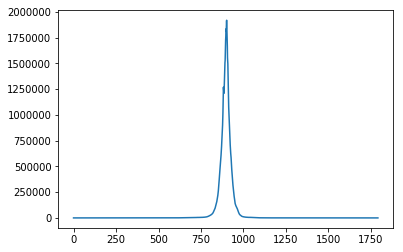

In [18]:
# You can use indices to select data.
# For example, to plot the (integrated) density for all z at t[100]
plt.plot(data[26,:,100])

<xarray.DataArray ()>
array(81.208376)
Coordinates:
    fields   |S1 'd'
    taxis    float64 100.0
    zaxis    float64 -2.382e+03


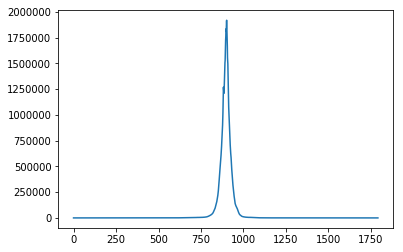

In [19]:
#If you know which variable you want, you can use its name (similar to pandas) rather than its index to choose or slice
#This uses the "sel" method:
print data.sel(fields='d')[300,100]
#Note that if you use xarray's "data.sel" function you must use the exact value stored in the coordinate array
plt.plot(data.sel(fields='d',taxis=100.0007).data)

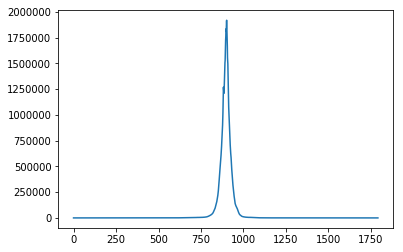

In [20]:
#The following would return an error because there is no value taxis=100
#plt.plot(data.sel(fields='d',taxis=100).data)
#However, you may use nearest-neighbor for lookups
plt.plot(data.sel(fields='d').sel(taxis=100,method='nearest'))

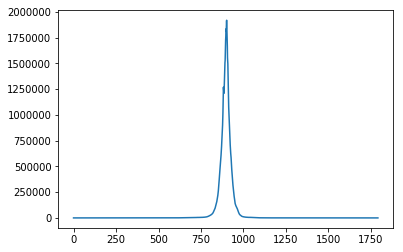

In [21]:
# This uses the "loc" method to obtain d values at all z for t[100]
data.loc['d'][:,100]
# You may combine "loc" and "sel"
plt.plot(data.loc['d'].sel(taxis=100,method='nearest'))

# Variables in zprof data
* All variables use conventional nomenclature, and are in code units
* Note that $B$ in the code is $B_{phys}/\sqrt{4 \pi}$
* v2, dM2, dEk2 used the perturbed y-velocity (i.e. $v_{y0}=-q \Omega x$ is subtracted first)
* However, M2 is the momentum in the y direction *without* subtracting out the background shear 
* T is calculated in units of K with the temperature dependent $\mu$ that is adopted
* Phie is the external gravitational potential, defined w.r.t the midplane
* Phisg is the self gravitational potential, defined w.r.t the z-boundaries
* gext and gsg are gravitational acceleration calculated using centered differences
* dW(ext/sg) = d$*$g(ext/sg) i.e. the contribution (without dz) to the weight $\int \rho g dz$
* Ber is the Bernoulli parameter including tidal potential (but note this is only *relative* because the self- and external grav. potentials do not have the same reference point)
* cool = $\langle n^2\Lambda(T)\rangle$ and heat = $\langle n\Gamma \rangle$
* dB, dPB, and dvA are from "turbulent" magnetic fields, i.e. the mean values at a given z are subtracted out first
* S(1/2/3) is the Poynting flux in each direction, ${\bf S} = {\bf B}\times ({\bf v} \times {\bf B})$ 
* s(1/2/3) is the passive scalar (not included in some simulations)
* variables starting with "p" and "m" are fluxes with "plus" and "minus" vertical velocities, respectively
    * for example, pFzd or mFzd is d*v_z considering only + or - values of velocity, respectively
* The Poynting flux is decomposed into 4 terms,
    * p/mSz=p/m(SzEm1+SzEm2+SzvB1+SzvB2)
$$S_z = B_x^2v_z + B_y^2 v_z -B_z B_x v_x - B_z B_y v_y$$
* Rxy(L/R) and Mxy(L/R) are Reynolds and Maxwell stresses calculated at left and right boundaries of the domain

### Example 1: spacetime (t,z) image plots

Text(0,0.5,'z')

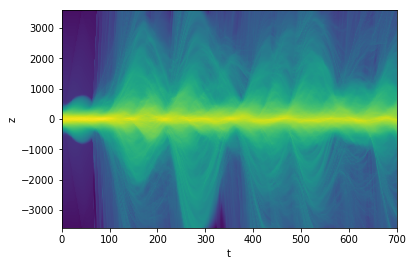

In [22]:
from matplotlib.colors import LogNorm,SymLogNorm,Normalize
z=data.zaxis
t=data.taxis
plt.imshow(data.loc['d'],norm=LogNorm(),origin='lower',
           extent=[min(t),max(t),min(z),max(z)],aspect='auto')
plt.xlabel('t')
plt.ylabel('z')

Text(0,0.5,'z')

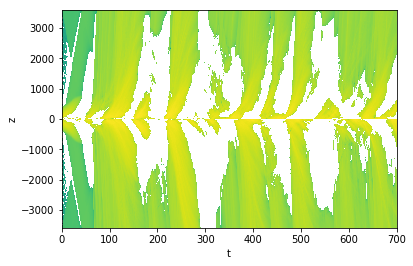

In [23]:
# net outgoing mass flux 
# (note that if the mass flux is negative, this is not shown in log scale)
sx=np.sign(data.zaxis)
plt.imshow(sx*(data.loc['pFzd']+data.loc['mFzd']),norm=LogNorm(),origin='lower',
           extent=[min(t),max(t),min(z),max(z)],aspect='auto')
plt.xlabel('t')
plt.ylabel('z')

### Example 2: time averaged profiles of a particular phase

<xarray.DataArray (zaxis: 1792)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
    fields   |S9 'd'
  * zaxis    (zaxis) float64 -3.582e+03 -3.578e+03 -3.574e+03 -3.57e+03 ...


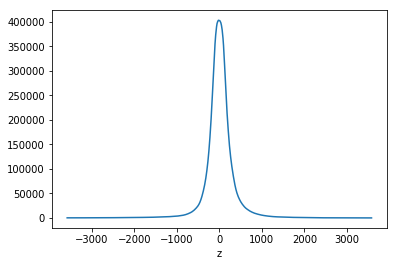

In [24]:
# simple time average for entire period 
# for operations, you may use the index or name of the "direction"
data_w=xr.open_dataarray(warm)
data_w.load()
data_w.close()
dmean = data_w.loc['d'].mean(axis=1)
dm2=data_w.loc['d'].mean(dim='taxis')
plt.plot(z,dmean)
plt.xlabel('z')
print dmean - dm2

<xarray.DataArray (zaxis: 1792)>
array([92295.977208, 92117.356125, 91962.48433 , ..., 40316.17094 ,
       40392.569801, 40494.928775])
Coordinates:
    fields   |S9 'A'
  * zaxis    (zaxis) float64 -3.582e+03 -3.578e+03 -3.574e+03 -3.57e+03 ...


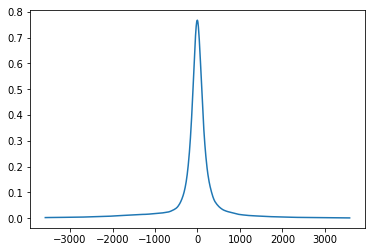

In [25]:
# To convert to physical values, you must renormalize using the area
#This averages over all time at a given height and then divides by the mean area in that phase at that height
Amean = data_w.loc['A'].mean(dim='taxis')
print Amean
plt.plot(z,dmean/Amean)

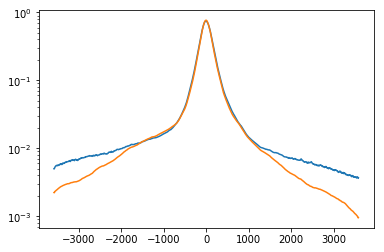

In [26]:
# This divides by area first to obtain the average value in a given phase at a given z and t, 
#     and then takes the mean over time.  The result differs from the above method (which effectively weights by area).   
dmean2 = (data_w.loc['d']/data_w.loc['A']).mean(dim='taxis')
plt.semilogy(z,dmean2)
plt.semilogy(z,dmean/Amean)

In [27]:
#We use set_units from pyathena for units conversions
# This uses units and constants from astropy
import sys
sys.path.pop(1)
sys.path.insert(0,'../')
import pyathena as pa
pa.__file__

'../pyathena/__init__.pyc'

0.0352682242985 solMass / pc2
0.977792221673 Myr
dz= 4.0 pc


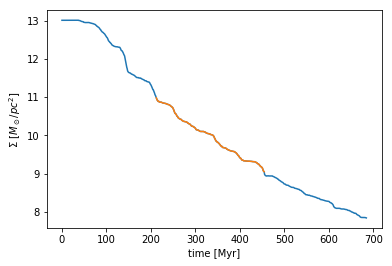

In [28]:
# time average for a selected time range
units=pa.set_units(muH=1.4271)
surf_unit=(units['density']*units['length']).to('Msun/pc^2')
print surf_unit
t_unit=units['time'].to('Myr')
print t_unit
dz=z[1]-z[0]
print('dz= {} pc'.format(dz.values))
surf=(data.loc['d']/data.loc['A']).sum(dim='zaxis')*dz*surf_unit
plt.plot(data.taxis*t_unit,surf)
plt.xlabel('time [Myr]')
plt.ylabel('$\Sigma\ [M_\odot/pc^2]$')

trange=(surf>9) & (surf <11)
data_selected=data[:,:,trange]

plt.plot(t[trange]*t_unit,surf[trange])

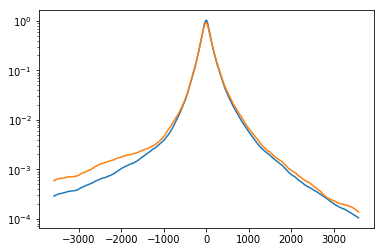

In [29]:
# time-averaged vertical density profile
dmean2 = (data.loc['d']/data.loc['A']).mean(dim='taxis')
dmean2_selected = (data_selected.loc['d']/data_selected.loc['A']).mean(dim='taxis')
plt.semilogy(z,dmean2)
plt.semilogy(z,dmean2_selected)

### Example 3: Midplane Pressures

In [30]:
def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xr.open_dataarray(path) as ds:
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            print path
            ds.load()
            return ds

    datasets = [process_one_path(p) for p in files]
    combined = xr.concat(datasets, dim)
    return combined

# here we use the above macro to read in and sum over phases from the first three files
two_phase = read_netcdfs(zprof_fnames[:3], dim='phase').sum(dim='phase')

/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase1.zprof.nc
/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase2.zprof.nc
/tigress/changgoo/MHD_4pc_new/zprof_merged/MHD_4pc_new.phase3.zprof.nc


In [31]:
two_phase

<xarray.DataArray (fields: 85, zaxis: 1792, taxis: 702)>
array([[[      0.      ,       0.      , ...,   11072.      ,   12560.      ],
        [      0.      ,       0.      , ...,   11024.      ,   14352.      ],
        ...,
        [      0.      ,       0.      , ...,   10224.      ,   10176.      ],
        [      0.      ,       0.      , ...,   10544.      ,    9904.      ]],

       [[      0.      ,       0.      , ...,     487.276096,    -943.04408 ],
        [      0.      ,       0.      , ...,     426.631983,   -1474.364251],
        ...,
        [      0.      ,       0.      , ...,   -2006.283459,   -1077.098333],
        [      0.      ,       0.      , ...,   -2251.514331,   -1065.477246]],

       ...,

       [[      0.      ,       0.      , ...,   -3661.06595 ,   -2856.297085],
        [      0.      ,       0.      , ...,   -3150.299724,   -3970.383859],
        ...,
        [      0.      ,       0.      , ...,   36291.770182,   35120.510133],
        [      0. 

In [32]:
# an alternative is to read in separately and combine
data_c=xr.open_dataarray(cold)
data_u=xr.open_dataarray(unst)
twop=data_c + data_u + data_w
#twop
diff = (twop.loc['d'] -two_phase.loc['d']).sum(axis=1).sum(axis=0)
print diff

<xarray.DataArray ()>
array(0.)
Coordinates:
    fields   |S9 'd'


In [33]:
units

{'density': <Quantity 0.03526822 solMass / pc3>,
 'gravitational_potential': <Quantity 1. km2 / s2>,
 'length': <Quantity 1. pc>,
 'magnetic_field': <Quantity 0.54768522 uG>,
 'mass': <Quantity 0.03526822 solMass>,
 'muH': <Quantity 2.38699871e-24 g>,
 'number_density': <Quantity 1. 1 / cm3>,
 'pressure': <Quantity 2.38699871e-14 erg / cm3>,
 'temperature': <Quantity 1. K>,
 'time': <Quantity 0.97779222 Myr>,
 'velocity': <Quantity 1. km / s>}

In [34]:
#This selects just the data with |z| < 10 pc 
zidx= np.abs(z) < 10
data_selected=two_phase[:,zidx,:]

In [38]:
const=astropy.constants
tMyr=data_selected.taxis*units['time'].to('Myr').value
Pok_unit=(units['pressure']/const.k_B).cgs.value
print Pok_unit
#This averages thermal pressure over the selected range of z (axis=0), then converts to P/k in cgs units 
Pth=(data_selected.loc['P']/data_selected.loc['A']).mean(axis=0)*Pok_unit
#This uses 2*Ek3=rho*v_z^2 and averages over the selected range of z (axis=0)
Pturb=(2.0*data_selected.loc['Ek3']/data_selected.loc['A']).mean(axis=0)*Pok_unit

#This is the total magnetic pressure averaged over the selected range of z (axis=0)
Pmag=0.5*(data_selected.loc['PB1']/data_selected.loc['A'])
Pmag+=0.5*(data_selected.loc['PB2']/data_selected.loc['A'])
Pmag+=0.5*(data_selected.loc['PB3']/data_selected.loc['A'])
Pmag=Pmag.mean(axis=0)*Pok_unit

#This computes (1/2(B^2) -B_z^2) for the mean B-field at each z
oPmag=0.5*(data_selected.loc['B1']/data_selected.loc['A'])**2
oPmag+=0.5*(data_selected.loc['B2']/data_selected.loc['A'])**2
oPmag-=0.5*(data_selected.loc['B3']/data_selected.loc['A'])**2
oPmag=oPmag.mean(axis=0)*Pok_unit

#This computes (1/2(B^2) -B_z^2) for the turbulent B-field at each z, i.e. 
tPmag=(data_selected.loc['dPB1']/data_selected.loc['A'])
tPmag+=(data_selected.loc['dPB2']/data_selected.loc['A'])
tPmag-=(data_selected.loc['dPB3']/data_selected.loc['A'])
tPmag=tPmag.mean(axis=0)*Pok_unit

#Midplane density

den=data_selected.loc['d'].mean(axis=0)


172.889672937


Text(0,0.5,'$P/k_B [{\\rm cm^{-3} K}]$')

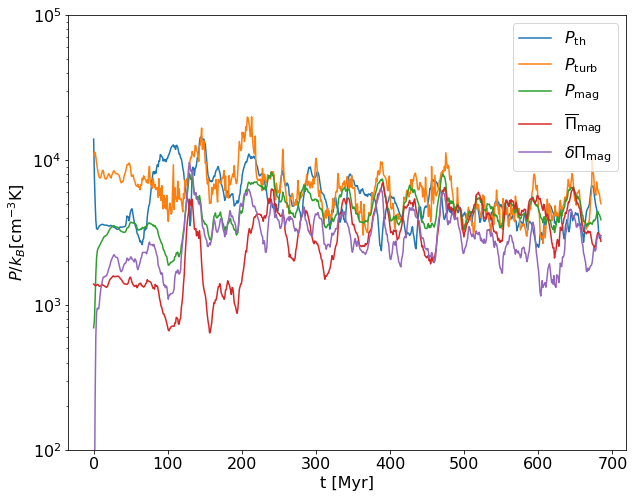

In [44]:
plt.rcParams['font.size']=16
fig=plt.figure(figsize=(10,8))
plt.plot(tMyr,Pth,label=r'$P_{\rm th}$')
plt.plot(tMyr,Pturb,label=r'$P_{\rm turb}$')
plt.plot(tMyr,Pmag,label=r'$P_{\rm mag}$')
plt.plot(tMyr,oPmag,label=r'$\overline{\Pi}_{\rm mag}$')
plt.plot(tMyr,tPmag,label=r'$\delta{\Pi}_{\rm mag}$')
lg=plt.legend(loc=1)
plt.ylim(1.e2,1.e5)
plt.yscale('log')
plt.xlabel('t [Myr]')
plt.ylabel(r'$P/k_B [{\rm cm^{-3} K}]$')

In [37]:
for label, P in zip(['thermal','turbulent','magnetic','mean Pi magnetic','turb. Pi magnetic'],[Pth,Pturb,Pmag,oPmag,tPmag]):
    print('{}/kB = {:8.2f}'.format(label, P[trange].data.mean()))

thermal/kB =  5577.09
turbulent/kB =  6315.20
magnetic/kB =  5192.30
mean Pi magnetic/kB =  3675.94
turb. Pi magnetic/kB =  3478.98


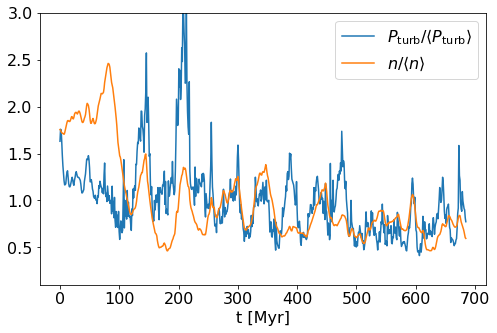

In [49]:
plt.figure(figsize=(8,5))
#plt.plot(tMyr,Pth/Pth.mean(),label=r'$P_{\rm th}/\langle P_{\rm th}\rangle$')
plt.plot(tMyr,Pturb/Pturb.mean(),label=r'$P_{\rm turb}/\langle P_{\rm turb}\rangle$')
plt.plot(tMyr,den/den.mean(),label=r'$n/\langle n\rangle$')
plt.ylim(.1,3)
plt.xlabel('t [Myr]')
lg=plt.legend(loc=1)
#two_phase.sel(fields=('d','P')).plot(x='taxis',y='zaxis')

Reading a history file:/tigress/changgoo/MHD_4pc_new/hst/MHD_4pc_new.hst.p


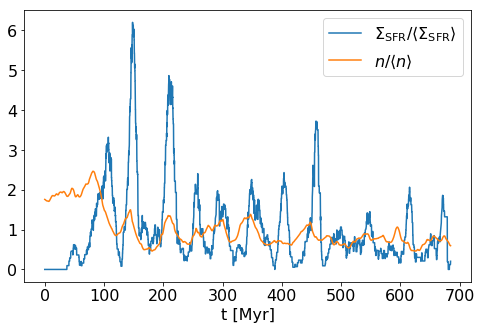

In [66]:
#We would like to compare to the SFR
#First we need to read in the history data
hstfile=base+problem_id+'/hst/'+problem_id+'.hst'
hst=pa.hst_reader(hstfile)
#print hst.keys()
plt.figure(figsize=(8,5))
plt.plot(hst.time*units['time'].to('Myr').value,hst.sfr10/hst.sfr10.mean(),label=r'$\Sigma_{\rm SFR}/\langle \Sigma_{\rm SFR}\rangle$')
#plt.plot(tMyr,Pturb/Pturb.mean(),label=r'$P_{\rm turb}/\langle P_{\rm turb}\rangle$')
plt.plot(tMyr,den/den.mean(),label=r'$n/\langle n\rangle$')
plt.xlabel('t [Myr]')
lg=plt.legend(loc=1)
#plt.plot()